# Examining the difference in dB/dt for different differencing schemes

#### SpacePy uses a central differencing scheme, Pulkkinen et al. (2013) used a forward difference.

We'll load one data file from CCMC, calculate dB/dt both ways, then find the bin maxima using the 20-minute non-overlapping bins used by Pulkkinen et al. Plots of the dB/dt time series and bin maxima will illustrate the difference in outcome. Then we'll finish by counting the number of "events" counted when we use the different methods.

In [1]:
import sys
import datetime as dt
import dateutil.parser as dup
import numpy as np

import spacepy.pybats.bats
import spacepy.toolbox as tb
import verify

%matplotlib inline
import matplotlib.pyplot as plt
import spacepy.plot as splot
splot.style('spacepy')

/home/smorley/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/smorley/.local/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
class CCMCMagFile(spacepy.pybats.bats.Mag):

    def __init__(self, fname, *args, **kwargs):
    #def __init__(self, nlines, time, gmvars=(), ievars=(), *args, **kwargs):
        from numpy import zeros

        super(spacepy.pybats.bats.Mag, self).__init__(*args, **kwargs)  # Init as PbData.

        with open(fname, 'r') as fh:
            contents = fh.readlines()

        header = [line.strip() for line in contents if not line[0].isdigit()]
        data = [line.strip() for line in contents if line[0].isdigit()]
        
        time = []
        nlines = len(data)
        self['dBn']=np.zeros(nlines)
        self['dBe']=np.zeros(nlines)
        self['dBd']=np.zeros(nlines)
        for idx, line in enumerate(data):
            line = line.split()
            line_t = [int(el) for el in line[:5]]
            time.append(dup.parse('{0}-{1:02d}-{2:02d}T{3:02d}:{4:02d}'.format(int(line[0]), int(line[1]), int(line[2]), int(line[3]), int(line[4]))))
            for key, col in [('dBn', 8), ('dBe', 9), ('dBd', 10)]:
                self[key][idx] = float(line[col])

        self['time']=np.asarray(time)
        self.attrs['nlines']=nlines
        iname = [line for line in header if line.startswith('#Inst')][0].split()[-1]
        self.attrs['instrument']=iname

        self.calc_h()
        self.calc_dbdt()

In [3]:
obsdata = CCMCMagFile('/mnt/projects/SolarWindPerturb/SWMF_inputs/Event5_obs/HRN.txt')

The "calc_dbdt" method in SpacePy is a central difference, with 2nd order forward and backward differences at each end.

### Calculate using a 1st order forward difference for comparison

In [4]:
tdiff_seconds = np.asarray(map(lambda x: x.total_seconds(), (obsdata['time'][1:]-obsdata['time'][:-1])))
dBedt_fd = (obsdata['dBe'][1:]-obsdata['dBe'][:-1])/tdiff_seconds
dBndt_fd = (obsdata['dBn'][1:]-obsdata['dBn'][:-1])/tdiff_seconds
forward_diff = np.sqrt(dBedt_fd**2 + dBndt_fd**2)
forward_diff_times = obsdata['time'][:-1] + (obsdata['time'][1:]-obsdata['time'][:-1])

In [5]:
central_diff_binmax, central_diff_time = tb.windowMean(obsdata['dBdth'], time=obsdata['time'], 
                                       winsize=dt.timedelta(minutes=20), overlap=dt.timedelta(0), 
                                       st_time=dt.datetime(2010,4,5), op=np.max)

In [6]:
forward_diff_binmax, forward_diff_time = tb.windowMean(forward_diff, time=forward_diff_times, 
                                       winsize=dt.timedelta(minutes=20), overlap=dt.timedelta(0), 
                                       st_time=dt.datetime(2010,4,5), op=np.max)

In [7]:
#truncate to 24 hour period of event 5
inds = tb.tOverlapHalf([dt.datetime(2010,4,5), dt.datetime(2010,4,6)], central_diff_time)
central_diff_binmax = np.asarray(central_diff_binmax)[inds]
forward_diff_binmax = np.asarray(forward_diff_binmax)[inds]
central_diff_time = np.asarray(central_diff_time)[inds]
forward_diff_time = np.asarray(forward_diff_time)[inds]

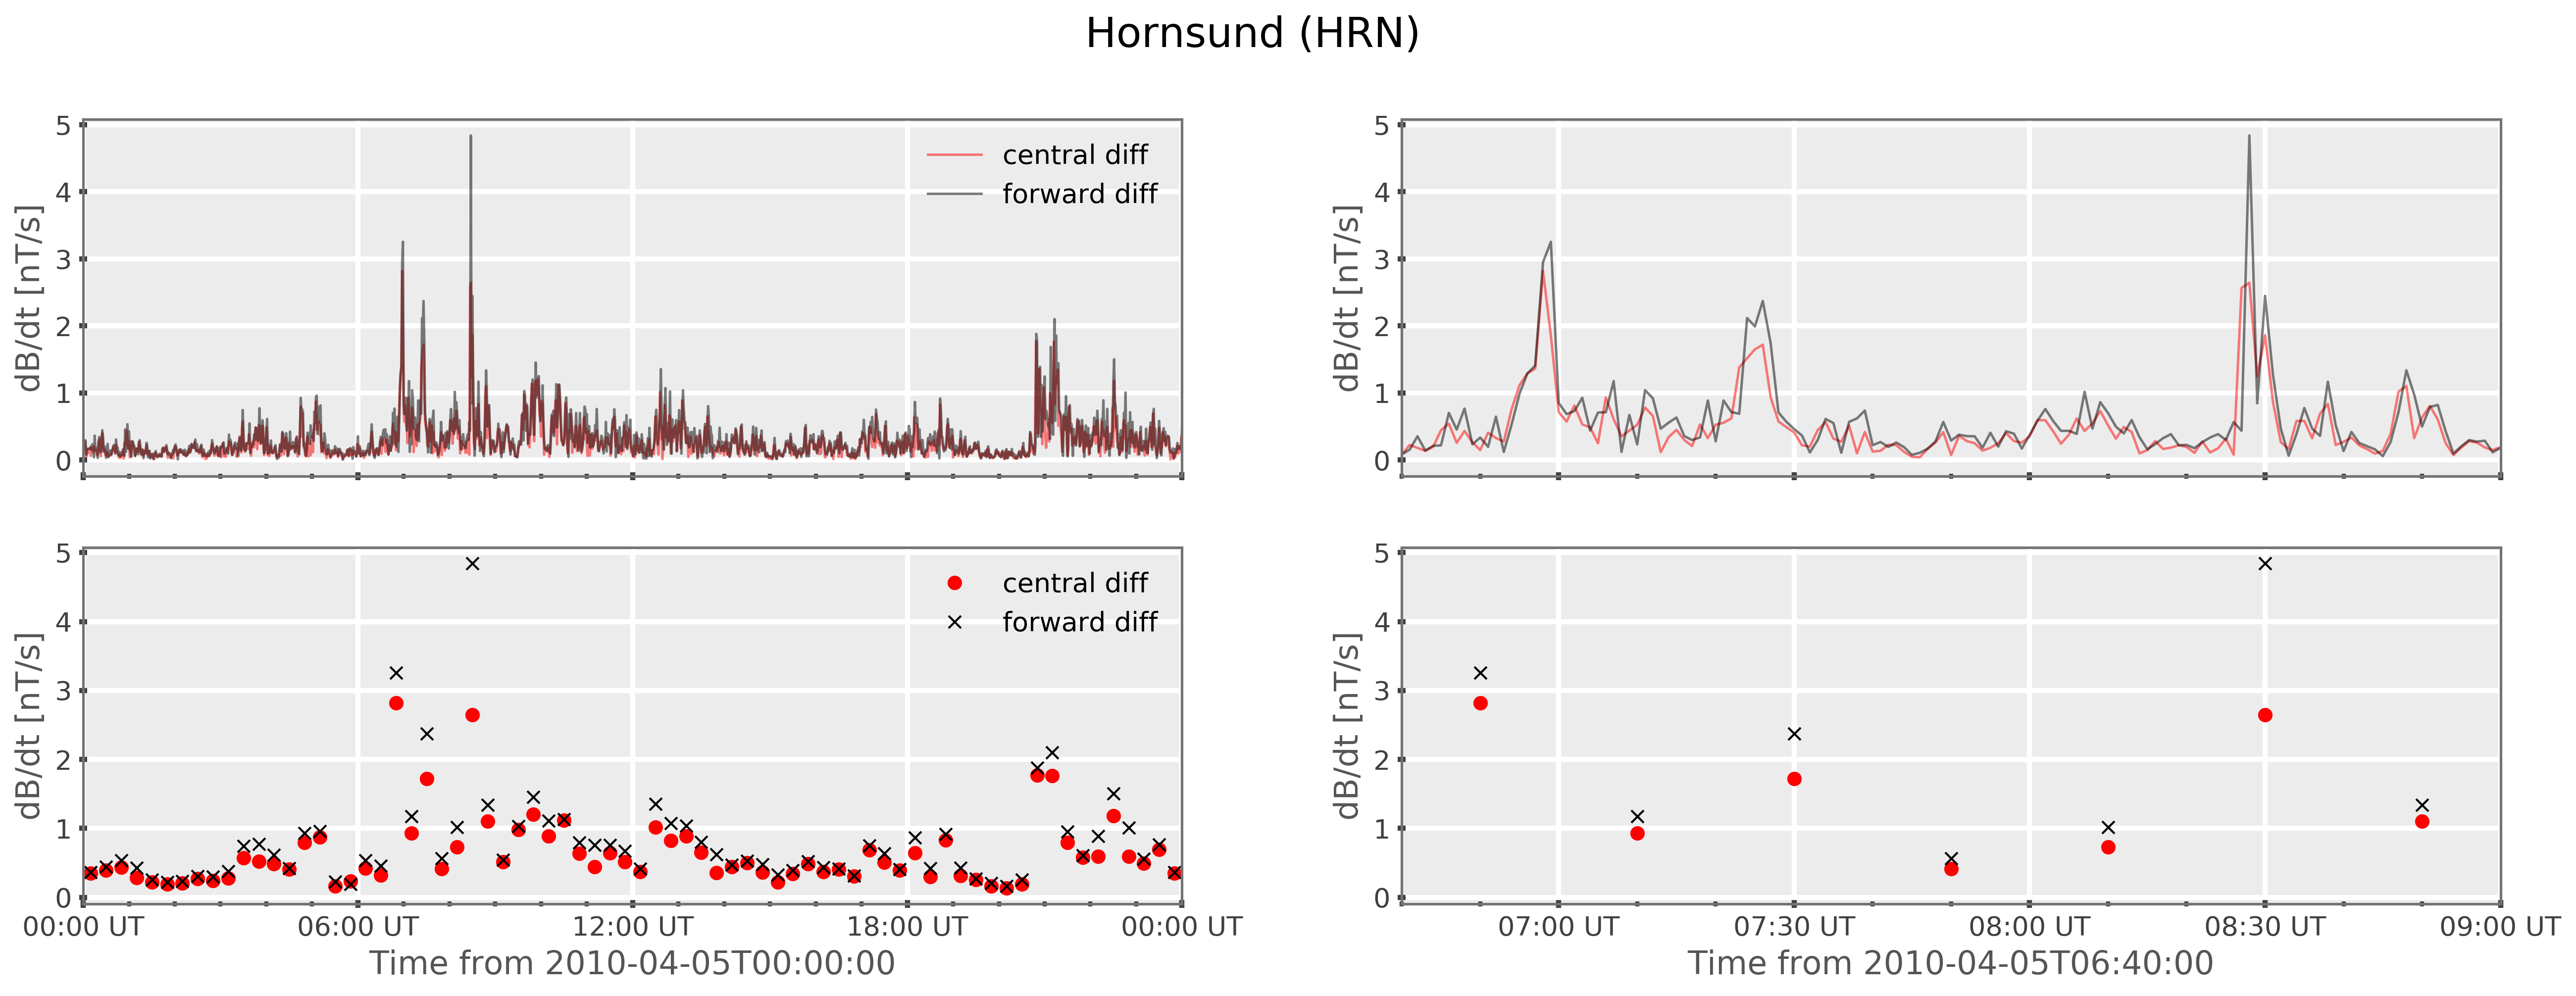

In [8]:
trange = [dt.datetime(2010,4,5), dt.datetime(2010,4,6)]
fig, axarr = plt.subplots(2, 2, figsize=(21,7))
fig.text(0.5, 0.95, 'Hornsund (HRN)', horizontalalignment='center', fontsize=20)
ax1 = axarr[0,0]
ax1.plot(obsdata['time'], obsdata['dBdth'], 'r-', label='central diff', alpha=0.5)
ax1.plot(forward_diff_times, forward_diff, 'k-', label='forward diff', alpha=0.5)
splot.applySmartTimeTicks(ax1, trange, dolabel=False, dolimit=True)
ax1.set_xticklabels([])
ax1.legend()
ax2 = axarr[1,0]
ax2.plot(central_diff_time, central_diff_binmax, 'ro', label='central diff')
ax2.plot(forward_diff_time, forward_diff_binmax, 'kx', label='forward diff')
splot.applySmartTimeTicks(ax2, trange, dolabel=True, dolimit=True)
ax2.legend()
trange = [dt.datetime(2010,4,5,6,40), dt.datetime(2010,4,5,9)]
ax3 = axarr[0,1]
ax3.plot(obsdata['time'], obsdata['dBdth'], 'r-', label='central diff', alpha=0.5)
ax3.plot(forward_diff_times, forward_diff, 'k-', label='forward diff', alpha=0.5)
splot.applySmartTimeTicks(ax3, trange, dolabel=False, dolimit=True)
ax3.set_xticklabels([])
ax4 = axarr[1,1]
ax4.plot(central_diff_time, central_diff_binmax, 'ro', label='central diff')
ax4.plot(forward_diff_time, forward_diff_binmax, 'kx', label='forward diff')
splot.applySmartTimeTicks(ax4, trange, dolabel=True, dolimit=True)
plt.subplots_adjust()

for ax in axarr.ravel():
    ax.set_ylabel('dB/dt [nT/s]')

### Difference in number of events for given threshold

In [9]:
thresholds = [0.3, 0.7, 1.1, 1.5]
for thresh in thresholds:
    N_event_central = (central_diff_binmax > thresh).sum()
    N_event_forward = (forward_diff_binmax > thresh).sum()

    print('Number of events (Threshold = {}):\nCentral difference  ->  {}\nForward difference  ->  {}'.
                                     format(thresh, N_event_central, N_event_forward))

Number of events (Threshold = 0.3):
Central difference  ->  58
Forward difference  ->  62
Number of events (Threshold = 0.7):
Central difference  ->  20
Forward difference  ->  31
Number of events (Threshold = 1.1):
Central difference  ->  9
Forward difference  ->  12
Number of events (Threshold = 1.5):
Central difference  ->  5
Forward difference  ->  6


## Using the forward difference overestimates the dB/dt relative to the central difference.
### One result of this overestimation is that the number of events (defined as threshold crossings) is overestimated.